# Part 3 Solutions Notebook

## Introduction

Linen is a sustainable fabric made from cellulosic fibers derived from the stem of the flax plant.<sup>1</sup> Both the fabric and the fibers are named as linen. Linen fibers are much stronger (two to three times) than coton fibers and they dry at a much faster rate yielding cool, absorbent fabrics.<sup>2</sup> Due to its porous nature, linen is a good heat conductor and widely preferred for clothing and bedding in the summer.<sup>2</sup>

Linen is used heavily in clothing like dresses, suits, skirts etc. and in home fashion products like curtains, sheets and towels. Detection of defective end-products is highly valuable to manufacturers in those industries and human centered detection methods are highly costly and open to lots of flaws. In offline quality control method, one of the generally used methods, production is stopped to take samples of the product and carry out the tests.<sup>3</sup> Since the production stops for each sample, the cost of monitoring the process increases. Sophisticated quality control using advanced image processing techniques would significantly improve detection and provide manufacturers with enough time to adjust their processes with a lower cost.

Also, laundries, textile manufacturers, or chemical vendors may encounter with undesired outcomes in the wash process if the monitoring and process control of linen is not properly performed during the production.<sup>4</sup>

## Background Information

For the further steps of this project, a literature review regarding the quality control for linen products could include what is considered a defect in a fabric and how to detect them through image processing. In this part of the report, both of those points will be elaborated by a number of past and concurrent studies.

The essential types of defects on a fabric for most manufacturers are warp or weft threads, oil stains and holes<sup>5</sup>. A missing thread in warp or weft is the irregularity of the texture in some specific parts of the fabric, which is the case for most of the linen images to be inspected in this project. Oil stains is another common flaw in the fabrics resulting from the lube applied to the textile machines. Lastly, the “void areas” on a fabric is also a defect stemming from the frictions during the displacement of the fabric roll<sup>5</sup>.

As to the image processing, greyscale filtering and binarization seem to be a widely used technique. Binarization simply means determining a threshold for the grey-scaled image and labelling the pixels to either one or zero, meaning white and black<sup>6</sup>. To determine a threshold, eyeballing on the histogram could be a naive method to implement<sup>8</sup>. Alternatively, a number of advanced methods namely, clustering, interclass variance and entropy are mentioned in some related articles<sup>6</sup>. After the binarization, some extra modifications to create an image consisting of larger white and black regions, in other words, to eliminate trivially small white areas, can also be applied for better results<sup>8</sup>.  

After the filtering and modification of the image, most of the studies focuses on data mining techniques for detection and classification of defects. Semi-algebraic networks is the method used in the conference paper of Blaga M. to identify defective and non-defective areas<sup>8</sup>, whereas, a modified version of K-means clustering is applied in the study of Jeong. S<sup>8</sup>. A totally algebraic approach without data mining techniques in the detection of defects can be found on the paper of Mohamed Jmali<sup>5</sup>. From white and black intensities in the sections of binarized image and the differences of number of white and black pixels in the adjacent rows, three different but similar methods are presented for three types of defects.  When it comes to the classification of the defects, neural networks and fuzzy c-means algorithms are deployed in the articles of Jmali<sup>5</sup> and Jeong S.<sup>7</sup>.

## Approach

The approach used for defect detection on the linen images in this project is basically dividing the [0,255] intensity range to a number of bins, and building an x-bar chart for proportion of each specific shade range(i.e., bin) in the patches of the whole grey-scaled image. To elaborate, if the proportion of a specific shade, for example very very dark grey, in a certain patch is highly different from the proportion of that shade in the other patches, the patch in question is probably a defective one. Therefore, building an x-bar chart over the patches of the image for each shade range could be a good starting point to identify the outliers.

Median filtering for eliminatation of the noise was the preprocessing applied because the non-defective but not smooth areas was a reason for erroneous defect detection and another reason was the insufficiency of shade difference.

After the preprocessing of the image and determination of the bin size by trial and error, a score for each patch is calculated by sum of distortion from the control limits over the bins. For example, for the first patch, if the proportion of the pixels having the intensity corresponding to first bin is above the upper control limit for that bin, the difference between this proportion and the upper limit is taken and scaled to the standard deviation. This calculation is made for each bin and a score is obtained for the first patch. If that score is above a threshold, this patch is marked defective. The same process is applied for each patch and the resulting image with red color on defective patches is illustrated.

## Results

The following libraries are used in our approach.

In [117]:
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.image import extract_patches_2d

We determined some constants to be used in our functions

In [118]:
plt.gray()
window_shape = (24, 24)
step_length = 8
bin_number = 16

<Figure size 432x288 with 0 Axes>

"getPatches" function is used to get the desired patches from the original image. These patches are windows of determined shape (24*24 in our case) and we slide these windows with determined step length (8 in our case) in x and y axis.

In [119]:
def getPatches(pixel_array, window_shape, step_length):
    edge_size = pixel_array.shape[0]
    whole_data = extract_patches_2d(pixel_array, window_shape)
    last_patch_index = edge_size - window_shape[0]
    indices = np.array(range(0,last_patch_index,step_length))
    desired_patch_indices = np.array([])
    for i in indices:
        desired_patch_indices = np.concatenate((desired_patch_indices, indices + i*last_patch_index))
    desired_patch_indices = np.array(desired_patch_indices, dtype="int32")
    patches = whole_data[desired_patch_indices]
    return patches

"getPixelRatios" function is used to get the pixel ratios of the original image and extracted patches with a determined number of bins. (16 in our case).<br>This function basically finds the pixel intensity (color tone) distribution for every patch. 

In [120]:
def getPixelRatios(pixel_array, bin_number):
    bin_size = int(256 / bin_number)
    shape = pixel_array.shape
    flattened = pixel_array.reshape((shape[0],-1))
    range_data = np.array(flattened / bin_size, dtype="int32")
    pixel_freqs = np.apply_along_axis(lambda arr: np.bincount(arr, minlength=bin_number), arr=range_data, axis=1)
    pixel_ratios = pixel_freqs / flattened.shape[1]
    return pixel_ratios

"calculateBinLimits" function is used for calculating upper and lower control limits for each bin (color tone) of a given patch.<br>
"xbarbar" is calculated by taking the mean of every color tone (column) and "sigma" is calculated by taking the standard deviation of every color tone (column) of a given patch. <br>
If "xbarbar" is very low (threshold of 0.001) we multiply "sigma" value by 2 in order to avoid getting false positive errors.<br>
Also, after these steps if "lower limit" came out to be negative we equalize it to zero.

In [121]:
def calculateBinLimits(patch_ratios, sigmalevel=3):
    xbarbar = patch_ratios.mean(axis=0)
    sigma = patch_ratios.std(axis=0)
    sigma[xbarbar <= 0.001] *= 2
    upper_limit = xbarbar + sigmalevel * sigma
    lower_limit = xbarbar - sigmalevel * sigma
    lower_limit[lower_limit < 0] = 0
    #upper_limit[xbarbar <= 0.001] *= 2
    return (xbarbar, upper_limit, lower_limit, sigma)

"getOutlierPatchIndices" function is used to detect outlier patches. First we find all the outlier patches by checking if that patch's pixel ratio is outside of **any** corresponding bin's control limits.<br> Then we calculate outlier scores by taking the difference between control limits and the corresponding pixel ratio scaled to sigma for the outlier patches. <br> After that we sum scores over the bins for each outlier patch and we return patches which have more than total outlier score of 2 (this value is determined by trial and error).

In [122]:
def getOutlierPatchIndices(pixel_ratios, bin_limits, window_shape, step_length, bin_number):
    patch_number = int((512-window_shape[0])/step_length)**2
    outlier_score=np.zeros((patch_number,bin_number))

    for bin_no in range(bin_number):
        bin_density = pixel_ratios[:,bin_no]
        outlier_indices_up=np.where(bin_density > bin_limits[1][bin_no])[0]
        outlier_score[outlier_indices_up, bin_no] += (pixel_ratios[outlier_indices_up, bin_no] - bin_limits[1][bin_no]) / bin_limits[3][bin_no]
        outlier_indices_down = np.where( bin_density < bin_limits[2][bin_no] )[0]
        outlier_score[outlier_indices_down, bin_no] += (bin_limits[2][bin_no] - pixel_ratios[outlier_indices_down, bin_no]) / bin_limits[3][bin_no]
    sum_score = np.sum(outlier_score, axis=1)
    indices = np.where(sum_score > 2)[0]
    return (indices, sum_score[indices])

"plotXBarChart" function is used to plot the X-bar chart for pixel ratios of extracted patches. <br> "Xbarbar" value and "sigma" is calculated by using extracted patches' mean value and standard deviation of ratios for every bin (color tone). <br> 3 Sigma control limits are used and lower control limits are leveled to zero if they came out negative in calculations.

In [123]:
def plotXBarChart(patch_ratios, bin_limits, figsize=[16,20]):
    xbarbar = bin_limits[0]
    upper_limit = bin_limits[1]
    lower_limit = bin_limits[2]

    bin_number = patch_ratios.shape[1]
    plt.figure(figsize=figsize)
    for i in range(bin_number):
        plt.subplot(bin_number/2,2,i+1)
        plt.title("Pixel Ratio X-Bar Chart - Bin #{0}".format(i))
        plt.xlabel('Patch number')
        plt.ylabel('Pixel Ratio (X-Bar)')
        plt.plot(patch_ratios[:,i])
        plt.axhline(upper_limit[i],color="r", linestyle='--', label='UCL/LCL')
        plt.axhline(lower_limit[i],color="r", linestyle='--')
        plt.axhline(xbarbar[i],color="g", label='CL')
        plt.legend()
        plt.tight_layout()
    plt.show()

After finding outlier patch indices by "getOutlierPatchIndices" function "fillOutliers" function uses this information to find the corresponding window of that index and mark the original image according to outlier score of the outlier patch (Higher outlier score leads to denser shades of red).

In [124]:
def fillOutliers(image, outlier_patch_infos, window_shape, step_length, figsize=[10,16], alpha=0.15):
    total_patch_in_row = int( (image.shape[0] - window_shape[0]) / step_length ) + 1
    outlier_patch_indices = outlier_patch_infos[0]
    plt.figure(figsize=figsize)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.tight_layout()
    plt.subplot(1,2,2)
    plt.imshow(image)
    origin_x = ( outlier_patch_indices % total_patch_in_row ) * step_length
    origin_y = np.array((outlier_patch_indices / total_patch_in_row) * step_length, dtype='uint32')
    for i in range(len(outlier_patch_indices)):
        corner_xs = [origin_x[i],
                  origin_x[i]+window_shape[0],
                  origin_x[i]+window_shape[0],
                  origin_x[i]]
        corner_ys = [origin_y[i],
                  origin_y[i],
                  origin_y[i]+window_shape[0],
                  origin_y[i]+window_shape[0]]
        plt.fill(corner_xs, corner_ys, 'r', alpha=min(1,alpha * outlier_patch_infos[1][i]))
    plt.tight_layout()
    plt.show()

After reading the image we use median filtering for preprocessing and get patches from this transformed greyscale image. <br> Then, we calculate pixel ratios for every patch and bin limits for each bin.<br> After that, we plot xbarcharts for each bin and detect and color outlier patches by using "getOutlierPatchIndices" and "fillOutliers" functions respectively.<br> This process is repeated for every image given and we have only given the output (x-bar charts for evey bin and detected defects in the image) for the first fabric image in this report.<br> Other outputs are given in the appendix [notebook]() 

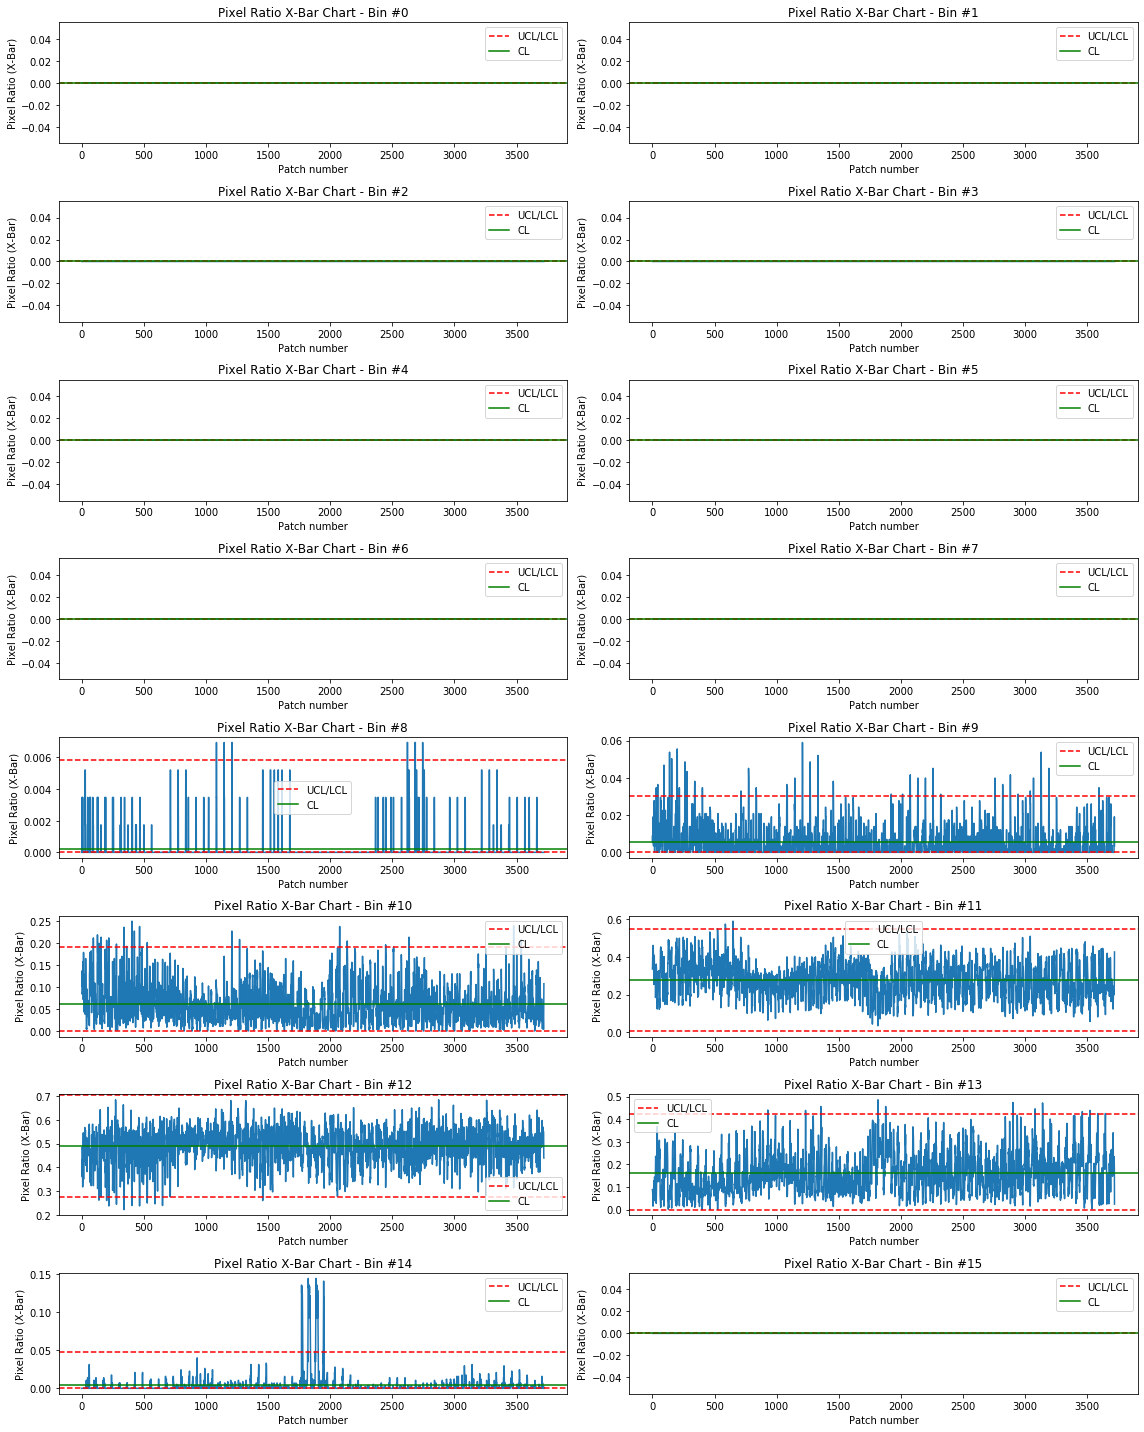

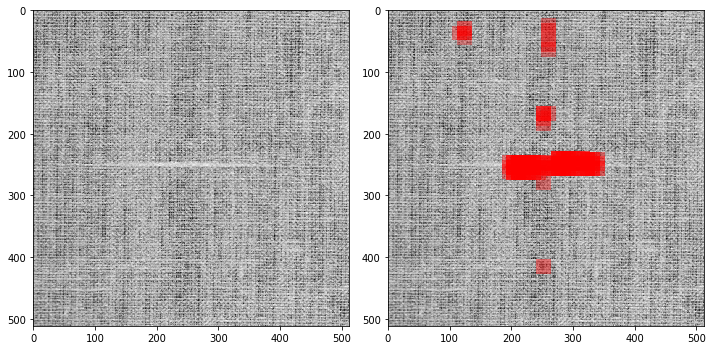

In [127]:
img1 =Image.open("Images/Fabric1.jpg").convert('L')
median_blurred = img1.filter(ImageFilter.MedianFilter(size=3))
not_blurred = np.array(img1)
pix1 = np.array(median_blurred)
patches1 = getPatches(pix1, window_shape, step_length)
patch1_pixel_ratios = getPixelRatios(patches1, bin_number)
image1_bin_limits = calculateBinLimits(patch1_pixel_ratios)
plotXBarChart(patch1_pixel_ratios, image1_bin_limits)
outliers = getOutlierPatchIndices(patch1_pixel_ratios, image1_bin_limits, window_shape, step_length,bin_number)
fillOutliers(not_blurred, outliers, window_shape, step_length)

## Conclusions and Future Work

## References

<sup>1</sup> https://textilelearner.blogspot.com/2012/01/linen-fiber-characteristics-of-linen.html

<sup>2</sup> https://www.thespruce.com/definition-of-linen-fabric-1976785

<sup>3</sup> https://www.textilemates.com/textile-testing-quality-control-fibre-testing-fabric-testing-yarn-testing

<sup>4</sup> https://www.almnet.org/page/TestPiece

<sup>5</sup> Jmali Mohamed, Zitouni Baghdadi And Sakli Faouzi " Classification of Fabrics Defects Using Image Analysis and Fuzzy C‐Means Method", International Conference of Applied Research On Textile, Citrat‐6, Hammamet, Tunisia, November 13 – 15, 2014.

<sup>6</sup> Jeong. S, Choi. H, Kim. S, Jaung. J.Y and Kim. S. H (2001): “Detecting Fabric Defects with Computer Vision and Fuzzy Rule Generation. Part I: Defect Classification by Image Processing”, Textile Research Journal, 71(6), pp. 518‐526.

<sup>7</sup> Jeong. S, Choi. H, Kim. S, Jaung. J.Y and Kim. S. H (2001): “Detecting Fabric Defects with Computer Vision and Fuzzy Rule Generation. Part II: Defect Identification by a Fuzzy Expert System”, Textile Research Journal, 71(6), pp. 563‐573.

<sup>8</sup> Blaga Mirela (2009): “Computer Vision Systems for Textiles Quality Control”, The 6th International Conference Management of Technological Changes, Greece, September 2009.

> **NOTE:** The source code is available at [here](https://github.com/BU-IE-582/fall19-akinelden/blob/master/Project_Part3/Part3.ipynb) 